In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import missingno as msno

%matplotlib inline

#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 200)

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
path_data = 'data.csv'
path_sample = 'sample_submission.csv'
data = pd.read_csv(path_data, index_col='row_id')
sub = pd.read_csv(path_sample)

In [31]:
data.shape

(1000000, 80)

In [32]:
data

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
row_id,,,,,,,,,,,,,,,,,,,,,
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,2.891854,3.105002,-3.470520,NaN,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502


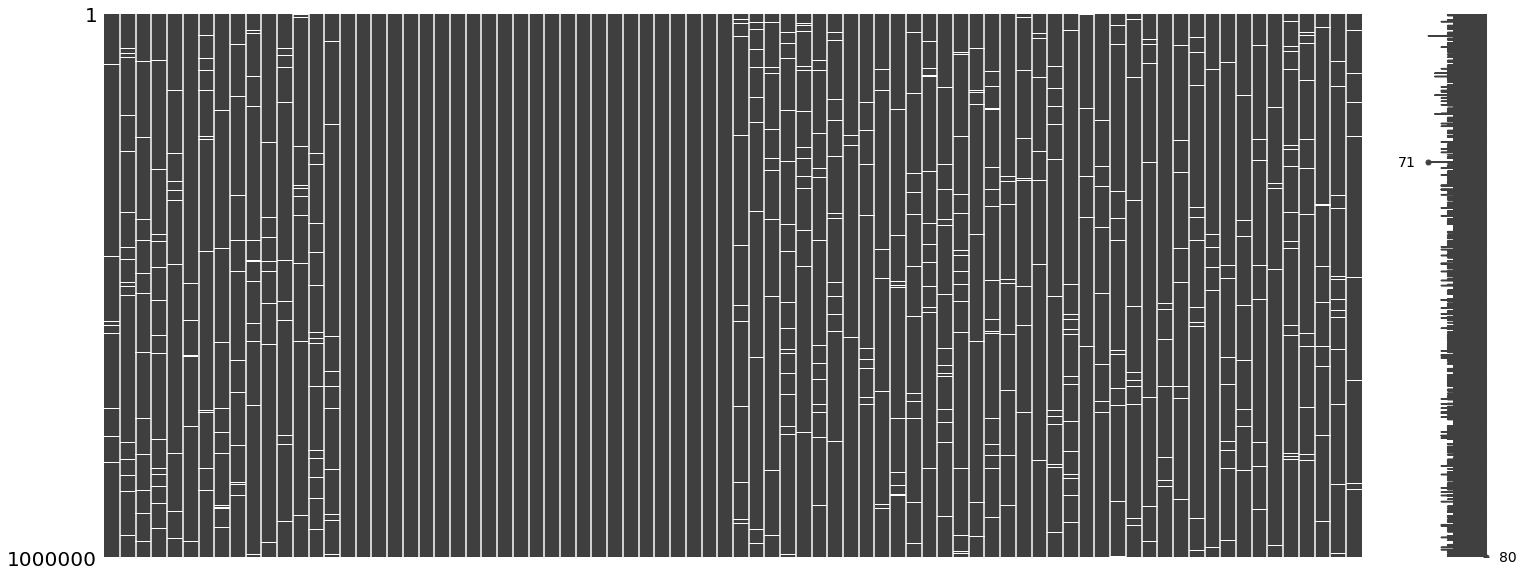

In [33]:
msno.matrix(data)

In [34]:
print(f"Le dataset comporte {data.isna().sum().sum() / data.size * 100} % de Nans")

Le dataset comporte 1.25 % de Nans


In [35]:
data.dtypes.value_counts()

float64    55
int64      25
dtype: int64

In [36]:
#sélection de toutes les colonnes 

mask_int64 = data.dtypes == 'int64'

In [37]:
#liste des colonnes int64
data.loc[:, data.columns[mask_int64]].columns

Index(['F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6', 'F_2_7',
       'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13', 'F_2_14',
       'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20', 'F_2_21',
       'F_2_22', 'F_2_23', 'F_2_24'],
      dtype='object')

In [38]:
def split_cols(col):
    splitted = col.split('_')
    return splitted[1], splitted[2]

F_2_xx : int64
F_x_yy (x!=2) : float 64

In [39]:
#vérification du nombre de nans dans les colonnes commençant par F_2

print(f"Les colonnes commençant par F_2 possèdent au total {data.rename(columns=lambda x: split_cols(x)[0]).loc[:,'2'].isna().sum().sum()} Nans")

Les colonnes commençant par F_2 possèdent au total 0 Nans


In [40]:
pearsoncorr = data.loc[:, data.columns[~mask_int64]].corr()

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(np.abs(pearsoncorr), 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [ ]:
#zoom sur les corrélations entre les colonnes commençant par F_4 seulement 

pearsoncorr_4 = pearsoncorr.loc[[row for row in pearsoncorr.index if row.split('_')[1] == '4'],
                                [col for col in pearsoncorr.columns if (col.split('_')[1] == '4')]]

plt.figure(figsize=(15, 7))
sns.heatmap(np.abs(pearsoncorr_4), 
            xticklabels=pearsoncorr_4.columns,
            yticklabels=pearsoncorr_4.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [ ]:
print(f"""Les colonnes comportant des nans ont en moyenne {round(data.loc[:, data.columns[~mask_int64]].isna().mean().mean()*100, 2)} % de nans
avec une moyenne minimale de {round(data.loc[:, data.columns[~mask_int64]].isna().mean().min()*100,2)} % de nans
et une moyenne maximale de {round(data.loc[:, data.columns[~mask_int64]].isna().mean().max()*100, 2)} % de nans""")

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import random


list_F_4 = [col for col in pearsoncorr.columns if (col.split('_')[1] == '4')]
data_F_4 = data.loc[:, list_F_4]

d = {}

train_percentage = 1

for col_4 in list_F_4:
    clf = LGBMRegressor(n_estimators=20000,metric='r2')
    X, y = data_F_4[set(list_F_4).difference({col_4})], data_F_4[[col_4]]

    idx_train = list(y[~y[col_4].isna()].index)
    train_size = round(len(idx_train)*train_percentage)
    idx_train = random.sample(idx_train, train_size)
    idx_test = list(y[y[col_4].isna()].index)

    X_train , y_train, X_test, y_test = X.loc[idx_train], y.loc[idx_train], X.loc[idx_test], y.loc[idx_test]
    print("Beginning ", col_4, "training with training size: ", X_train.shape[0])
    clf.fit(X_train, y_train)
    d[col_4] = clf.predict(X_test)
    print(col_4 + " processed")
    score=clf.score(X_train, y_train)
    print('R2 of this column : ', score)

In [ ]:
for col in list(d.keys()):
    data[col][data[col].isna()] = d[col]

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(
         missing_values=np.nan,
         strategy='mean') 
data[:] = imp.fit_transform(data)

In [ ]:
data.isna().sum().sum()

In [ ]:
def automated_sub_func_melt(data, sub):

    melt_data = pd.melt(data.reset_index(), id_vars='row_id', value_vars=data.columns, var_name='Column', value_name='Value')
    melt_data['row_id'] = melt_data['row_id'].astype(np.int32)
    melt_data['row-col'] = melt_data['row_id'].astype(str) + '-' + melt_data['Column']
    melt_data = melt_data.loc[melt_data['row-col'].isin(sub['row-col']), :]
    melt_data['sort1'] = melt_data['Column'].str.split('_', expand=True)[1]
    melt_data['sort1'] = melt_data['sort1'].astype(np.int8)
    melt_data['sort2'] = melt_data['Column'].str.split('_', expand=True)[2]
    melt_data['sort2'] = melt_data['sort2'].astype(np.int8)
    melt_data.sort_values(['row_id', 'sort1', 'sort2'], ascending=True, inplace=True)
    sub['value'] = melt_data['Value'].values
    return sub

In [ ]:
import time 
start_time = time.time()
new_sub = automated_sub_func_melt(data, sub.copy())
print(time.time() - start_time, "seconds")
new_sub.head()

In [ ]:
path_save = '/content/drive/MyDrive/OpenClassRooms/Projet 8/predictions.csv'
new_sub.to_csv(path_save, index = False)